# Решение задач с помощью SQL

Нам нужно проанализировать данные о фондах и инвестициях и написать запросы к базе.

In [ ]:
# Подсчёт количества закрывшихся компаний
select COUNT(id)
from company
where status like '%closed%';

**Результат:**    
count    
2584

In [ ]:
# Количество привлечённых средств для новостных компаний США
select funding_total
from company
where country_code = 'USA'
and category_code = 'news'
order by funding_total desc

**Результат:**    
funding_total    
6.22553e+08    
2.5e+08     
1.605e+08    
1.28e+08    
1.265e+08    
7e+07    
6.9e+07    
...

In [ ]:
# Общая сумма сделок по покупке одних компаний другими в долларах
select sum(price_amount)
from acquisition
where term_code = 'cash'
and extract(year from acquired_at) in (2011, 2012, 2013)

**Результат:**    
sum    
1.37762e+11

In [ ]:
# Отображение имени, фамилии и названий аккаунтов людей, у которых названия аккаунтов начинаются на 'Silver'
select first_name,
       last_name,
       twitter_username
from people
where twitter_username like 'Silver%';

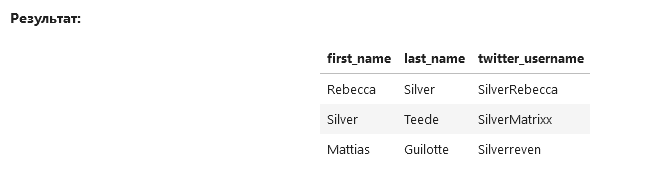

In [ ]:
# Вывод на экран всей информацию о людях, у которых названия аккаунтов содержат 'money', а фамилия начинается на 'K'
select *
from people
where twitter_username like '%money%'
and last_name like 'K%';

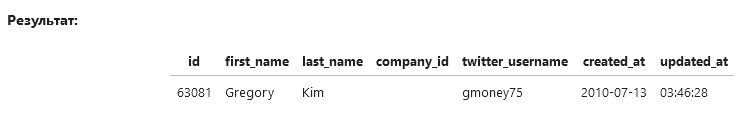

In [ ]:
# Отображение общей суммы привлечённых инвестиций для каждой страны
select country_code,
       sum(funding_total) as total_sum
from company
group by country_code
order by total_sum desc;

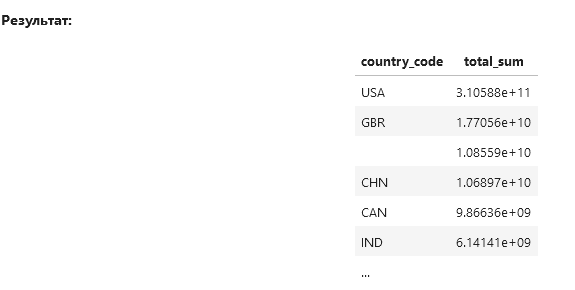

In [ ]:
# Составление таблицы из даты проведения раунда, мин и макс значения суммы инвестиций, привлечённых в эту дату
select funded_at,
       min(raised_amount) as mi,
       max(raised_amount) as ma
from funding_round
group by funded_at
having min(raised_amount) <> 0
and min(raised_amount) <> max(raised_amount);

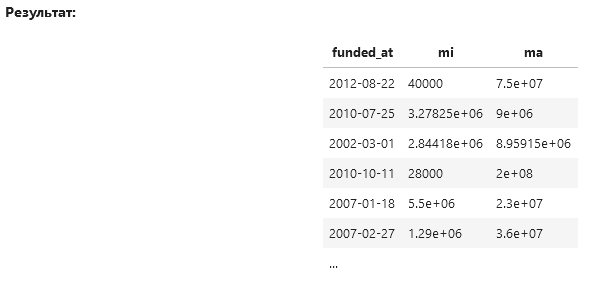

In [ ]:
# Создание поля с категориями
select *,
       case
           when invested_companies >= 100 then 'high_activity'
           when invested_companies >= 20 and invested_companies < 100 then 'middle_activity'
           when invested_companies < 20 then 'low_activity'
       end
from fund;

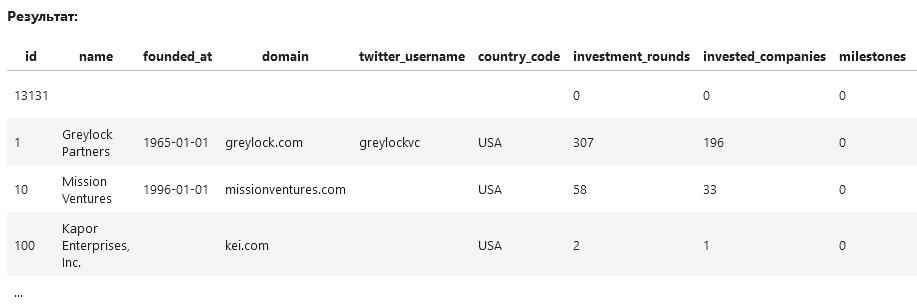

In [ ]:
# Подсчёт округлённого до ближайшего целого числа среднего количества инвестиционных раундов
SELECT CASE
           WHEN invested_companies>=100 THEN 'high_activity'
           WHEN invested_companies>=20 THEN 'middle_activity'
           ELSE 'low_activity'
       END AS activity,
       ROUND(AVG(investment_rounds))
FROM fund
group by activity

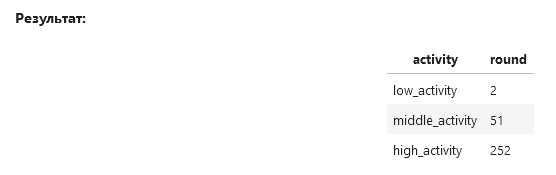

In [ ]:
# Подсчёт мин, макс и среднего числа компаний, в которые инвестировали фонды, основанные с 2010 по 2012 год включительно
select country_code,
       min(invested_companies) as min_in,
       max(invested_companies) as max_in,
       avg(invested_companies) as avg_in
from fund
where extract(year from founded_at) between 2010 and 2012
group by country_code
having min(invested_companies) > 0
order by avg_in desc, country_code
limit 10;

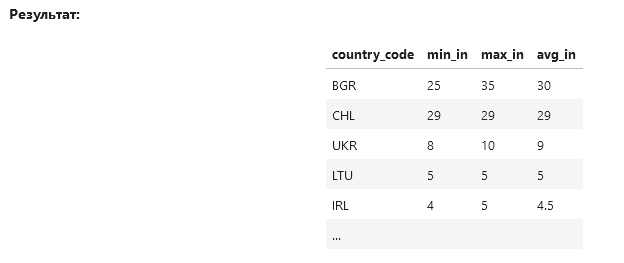

In [ ]:
# Отображение имени и фамилии всех сотрудников стартапов
select p.first_name,
       p.last_name,
       e.instituition
from people as p
left outer join education as e on p.id=e.person_id;

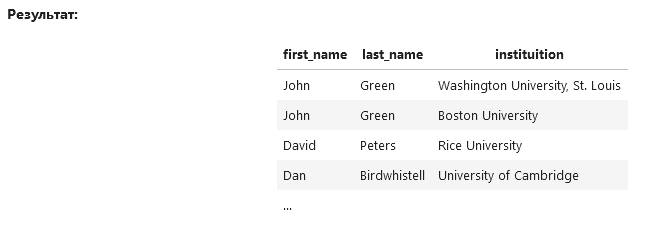

In [ ]:
# Поиск количества учебных заведений, которые окончили сотрудники компаний
select c.name,
       count(distinct e.instituition) as con
from company as c
left join people as p on c.id=p.company_id
join education as e on p.id=e.person_id
group by c.name
order by con desc
limit 5;

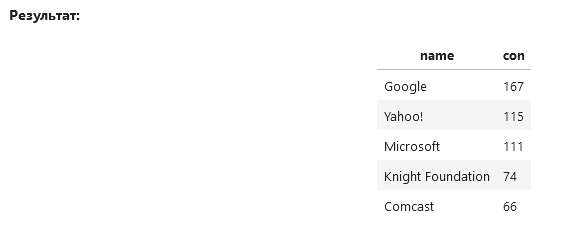

In [ ]:
# Список с уникальными названиями закрытых компаний, для которых первый раунд финансирования оказался последним
select name
from company
where id in (select company_id
               from funding_round
               where is_first_round=1
               and is_last_round=1)
and status='closed';

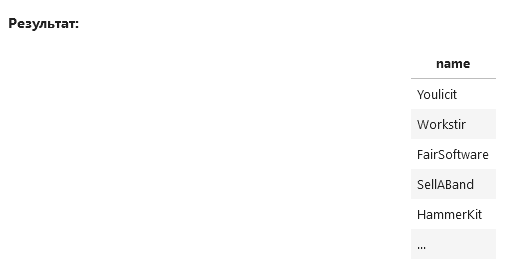

In [ ]:
# Cписок уникальных номеров сотрудников, которые работают в компаниях, отобранных в предыдущем задании
select distinct people.id
from people
where company_id in (select distinct company.id
                     from company
                     where id in (select company_id
                                  from funding_round
                                  where is_first_round=1
                                  and is_last_round=1)
                     and status='closed');

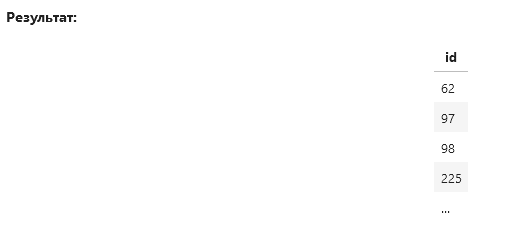

In [ ]:
# Таблица, в которую войдут уникальные пары с номерами сотрудников и учебным заведением, которое окончил сотрудник
select distinct e.instituition,
       pid.id
from
    (select distinct people.id
     from people
     where company_id in (select distinct company.id
                          from company
                          where id in (select company_id
                                       from funding_round
                                       where is_first_round=1
                                       and is_last_round=1)
                          and status='closed')) as pid
join education as e on e.person_id=pid.id;

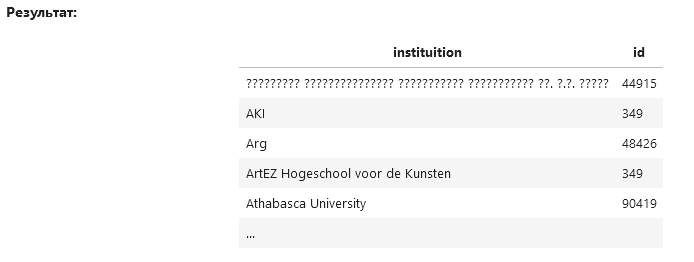

In [ ]:
# Количество учебных заведений для каждого сотрудника из предыдущего задания
select id,
       count(instituition) as con
from
    (select e.instituition,
           pid.id
    from
        (select distinct people.id
         from people
         where company_id in (select distinct company.id
                              from company
                              where id in (select company_id
                                           from funding_round
                                           where is_first_round=1
                                           and is_last_round=1)
                              and status='closed')) as pid
    join education as e on e.person_id=pid.id) as p
group by id;

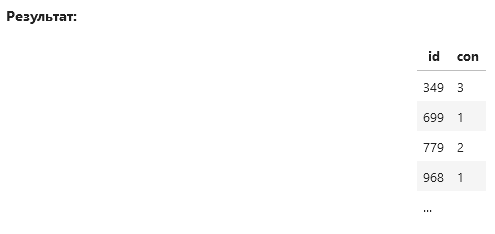

In [ ]:
# Вывод среднего числа учебных заведений, которые окончили сотрудники разных компаний
select avg(pon.con)
from
    (select id,
           count(instituition) as con
    from
        (select e.instituition,
               pid.id
        from
            (select distinct people.id
             from people
             where company_id in (select distinct company.id
                                  from company
                                  where id in (select company_id
                                               from funding_round
                                               where is_first_round=1
                                               and is_last_round=1)
                                  and status='closed')) as pid
        join education as e on e.person_id=pid.id) as p
    group by id) as pon;

**Результат:**    
avg    
1.41509 

In [ ]:
# Вывод среднего числа учебных заведений (не только уникальных), которые окончили сотрудники Facebook
select avg(pon.con)
from
    (select id,
           count(instituition) as con
    from
        (select e.instituition,
               pid.id
        from
            (select people.id
             from people
             where company_id in (select company.id
                                  from company
                                  where name = 'Facebook')) as pid
        join education as e on e.person_id=pid.id) as p
    group by id) as pon;

**Результат:**    
avg    
1.51111

In [ ]:
# Составление таблицы из полей
select f.name as name_of_fund,
       c.name as name_of_company,
       fr.raised_amount as amount
from investment as i
join company as c on i.company_id=c.id
join fund as f on i.fund_id=f.id
join funding_round as fr on i.funding_round_id=fr.id
where c.milestones > 6
and extract(year from fr.funded_at) in(2012, 2013);

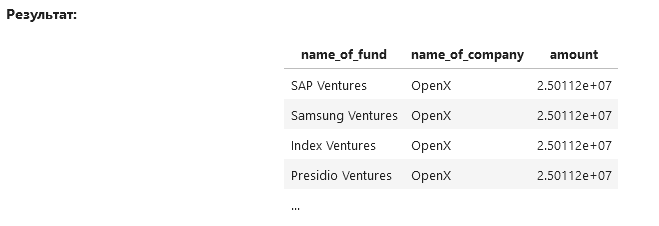

In [ ]:
# Выгрузка таблицы из полей
select c1.name as acquiring,
       a.price_amount as pa,
       c2.name as acquired,
       c2.funding_total as invest,
       round(a.price_amount / c2.funding_total) as quota
from acquisition as a
left join company as c1 on c1.id=a.acquiring_company_id
left join company as c2 on c2.id=a.acquired_company_id
where a.price_amount <> 0 
and c2.funding_total <> 0
order by pa desc, acquired
limit 10;

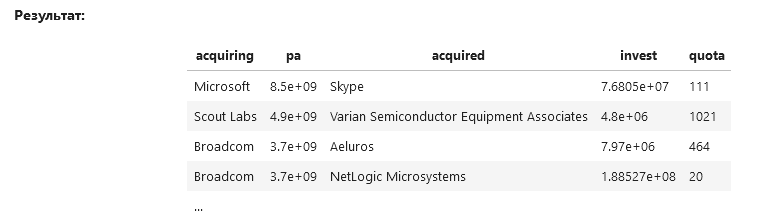

In [ ]:
# Выгрузка таблицы с названиями компаний из категории social, получившие финансирование с 2010 по 2013 год включительно
select c.name,
       extract(month from fr.funded_at::date)
from company as c
left join funding_round as fr on c.id=fr.company_id
where c.category_code='social'
and extract(year from fr.funded_at::date) between 2010 and 2013
and fr.raised_amount <> 0;

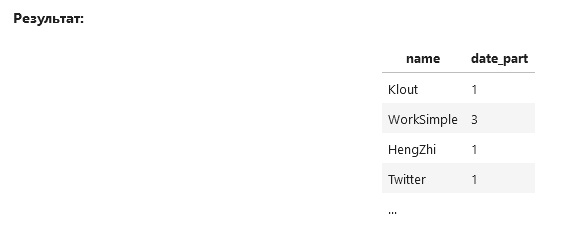

In [ ]:
# Отбор данных по месяцам с 2010 по 2013 год, когда проходили инвестиционные раунды
with
vrem_fund as (select extract(month from fr.funded_at::date) as month,
                     count(distinct f.name) as count_fund
              from fund as f
             join investment as i on f.id=i.fund_id
             join funding_round as fr on fr.id=i.funding_round_id
             where extract(year from fr.funded_at::date) between 2010 and 2013
             and f.country_code='USA'
             --and extract(month from fr.funded_at::date) is not null
             group by month),
vrem_acqu as (select extract(month from acquired_at::date) as month,
                     count(a.acquired_company_id) as count_comp,
                     sum(a.price_amount) as summa
              from acquisition as a
              --join company as c on a.acquiring_company_id=c.id
              --join funding_round as f on c.id=f.company_id
              where extract(year from acquired_at::date) between 2010 and 2013
              group by month)
select vf.month,
       vf.count_fund,
       va.count_comp,
       va.summa
from vrem_fund as vf
join vrem_acqu as va on vf.month=va.month
order by month;

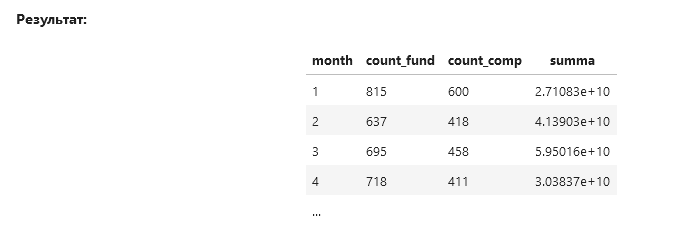

In [ ]:
# Составление таблицы со средней суммой инвестиций для стран со стартапами, зарегистрированными в 2011, 2012 и 2013 годах
with a as
(select country_code,
avg(funding_total) as sum_tot_2012
from company
where extract(year from founded_at::date)=2012
group by country_code),

b as
(select country_code,
avg(funding_total) as sum_tot_2013
from company
where extract(year from founded_at::date)=2013
group by country_code),

c as
(select country_code,
avg(funding_total) as sum_tot_2011
from company
where extract(year from founded_at::date)=2011
group by country_code)

select a.country_code,
       c.sum_tot_2011,
       a.sum_tot_2012,
       b.sum_tot_2013
from a
join b on a.country_code=b.country_code
join c on a.country_code=c.country_code
order by c.sum_tot_2011 desc;

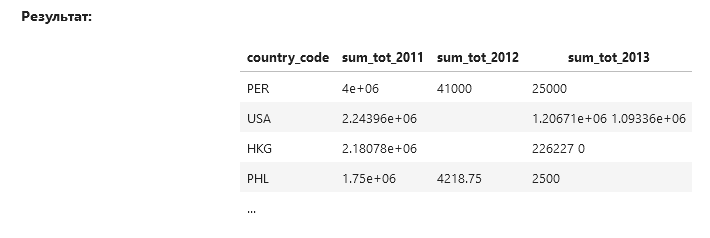